In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mat50 = np.load('np/lrgmat50.npy')
mat100 = np.load('np/lrgmat100.npy')
mat200 = np.load('np/lrgmat200.npy')

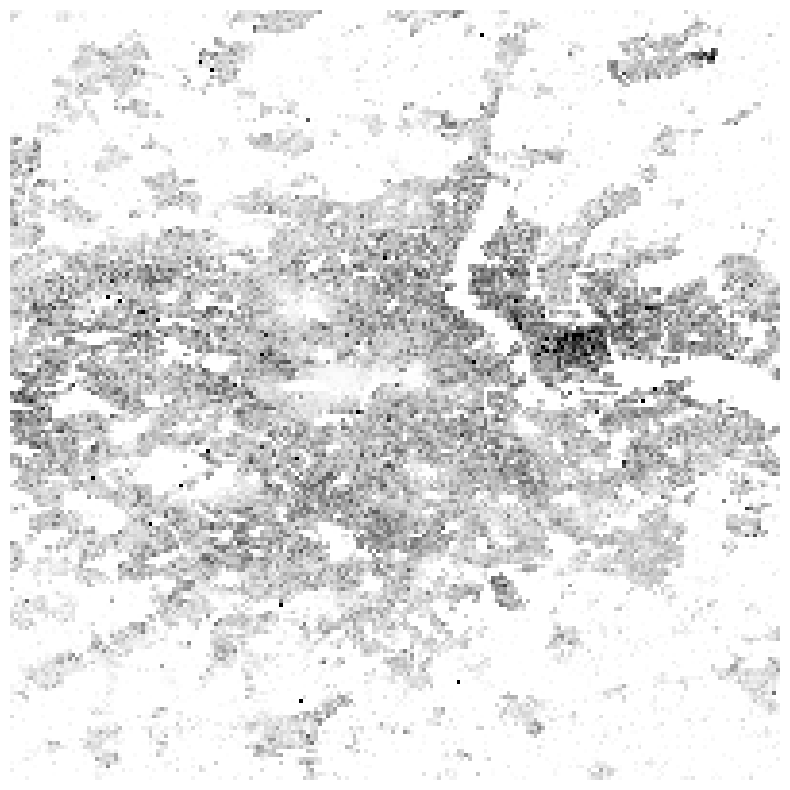

In [280]:
def smooth(mat, matsize, deg=2):
    smoothed = np.copy(mat)
    for i in range(matsize):
        for j in range(matsize):
            xr = np.r_[i - deg : i + deg + 1] % matsize
            xc = np.r_[j - deg : j + deg + 1] % matsize
            smoothed[i, j] = np.mean(smoothed[np.ix_(xr, xc)])
    return smoothed

def side2side(mat, matsize, deg=2):
    smoothed = smooth(mat, matsize, deg)

    fig, ax = plt.subplots(1, 2)
    matrices = [mat, smoothed]
    for i in range(2):
        ax[i].imshow(matrices[i], cmap='Greys')
        ax[i].axis('off')
    plt.show()

    return smoothed

# sm50 = side2side(mat50, 50, deg=1)
# sm100 = side2side(mat100, 100, deg=2)
# sm200 = side2side(mat200, 200, deg=3)
plt.figure(figsize=(10, 10))
plt.imshow(mat200, cmap='Greys')
plt.axis('off')
plt.show()

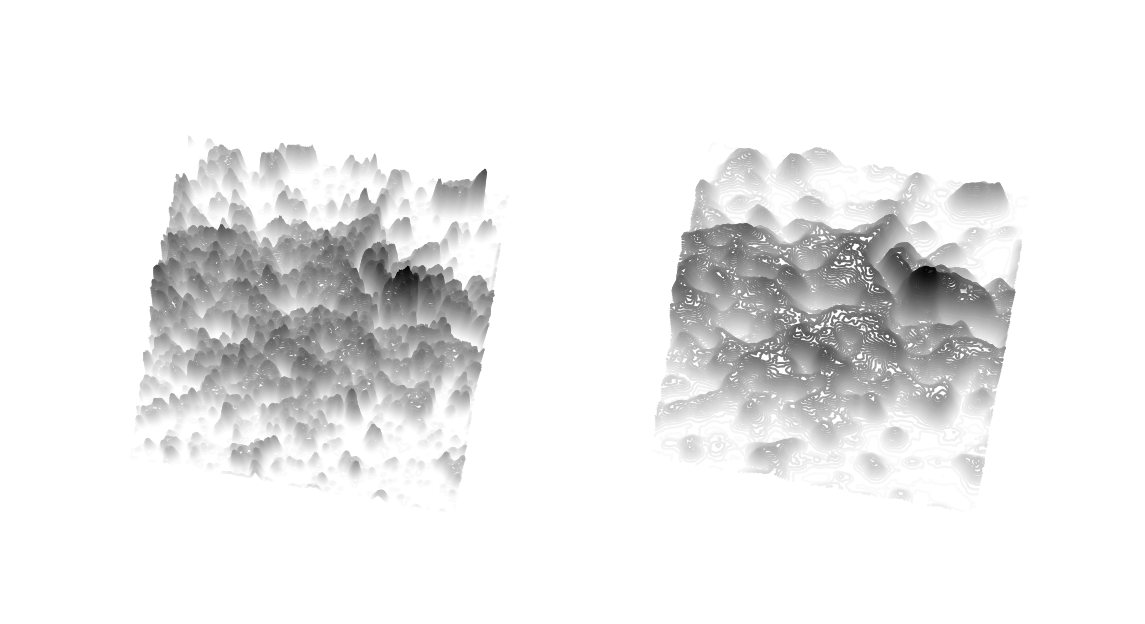

In [10]:
def threedim(matx, deg1, deg2, n=1, surface=False):
    size = matx.shape[0]
    x = y = np.arange(size)
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(20, 20))
    ax = {}
    for i in range(1, n+1):
        mat = smooth(matx, size, i**2)
        ax[i] = fig.add_subplot(1, 4, i, projection='3d')
        if surface:
            ax[i].plot_surface(-X, Y, mat, rstride=1, cstride=1, cmap='Greys', linewidth=0, antialiased=False)
        else:
            ax[i].contour3D(-X, Y, mat, 50, cmap='binary')
        ax[i].view_init(deg1, deg2)
        plt.axis('off')
    fig.tight_layout(pad=-6)
    # fig.savefig(f'plots/threex{size}{n}')
    plt.show()


threedim(mat200, 80, 100, 2)
# threedim(mat100, 70, 95, surface=True)

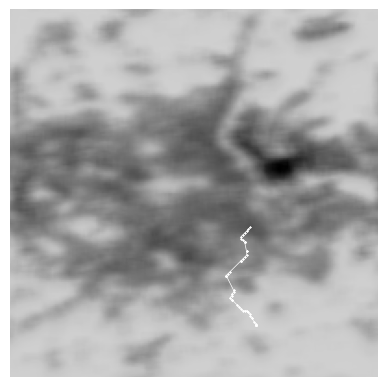

In [180]:
# FIX for steps larger than 1
def next(mat, index, step=1):
    i, j = index
    xr = np.r_[i - step : i + step + 1]
    xc = np.r_[j - step : j + step + 1]
    temp = mat[np.ix_(xr, xc)]
    argmin = np.argmin(temp)
    x, y = np.unravel_index(argmin, (step*2 + 1, step*2 + 1))
    return (x + i - step, y + j - step)

def descent(mat, start_ids):
    old_idx = start_ids
    ids_list = [start_ids]
    steps = [i for i in range(1, 20)]
    try:
        for _ in range(1, 300):
            for step in steps:
                new_idx = next(mat, old_idx, step)
                if mat[new_idx] == 0:
                    raise Exception
                ids_list.append(new_idx)
                diff = mat[*old_idx] - mat[*new_idx]
                old_idx = new_idx
                if diff > 0:
                    break
    except Exception:
        pass
    return ids_list

def buffer(mat, deg=100):
    buffered = np.copy(mat)
    def pad_with(vector, pad_width, iaxis, kwargs):
        pad_value = kwargs.get('padder', 10)
        vector[:pad_width[0]] = pad_value
        vector[-pad_width[1]:] = pad_value
    return np.pad(buffered, deg, pad_with, padder=float('inf'))

def plot_descent(smx, idx):   
    mat = buffer(smx)
    mat[-1, -1] = -40
    ids_list = descent(mat, idx)
    x, y = zip(*ids_list)
    plt.imshow(mat, origin='upper', cmap='Greys')
    plt.plot(y, x, '-x', markersize=1, linewidth=0.5, c='w')
    plt.axis('off')
    plt.xlim(100, 300)
    plt.ylim(300, 100)
    plt.show()


deg = 100
idx = np.unravel_index(np.nanargmax(sm200), sm200.shape)
start_idx = 218, 230
plot_descent(sm200, start_idx)


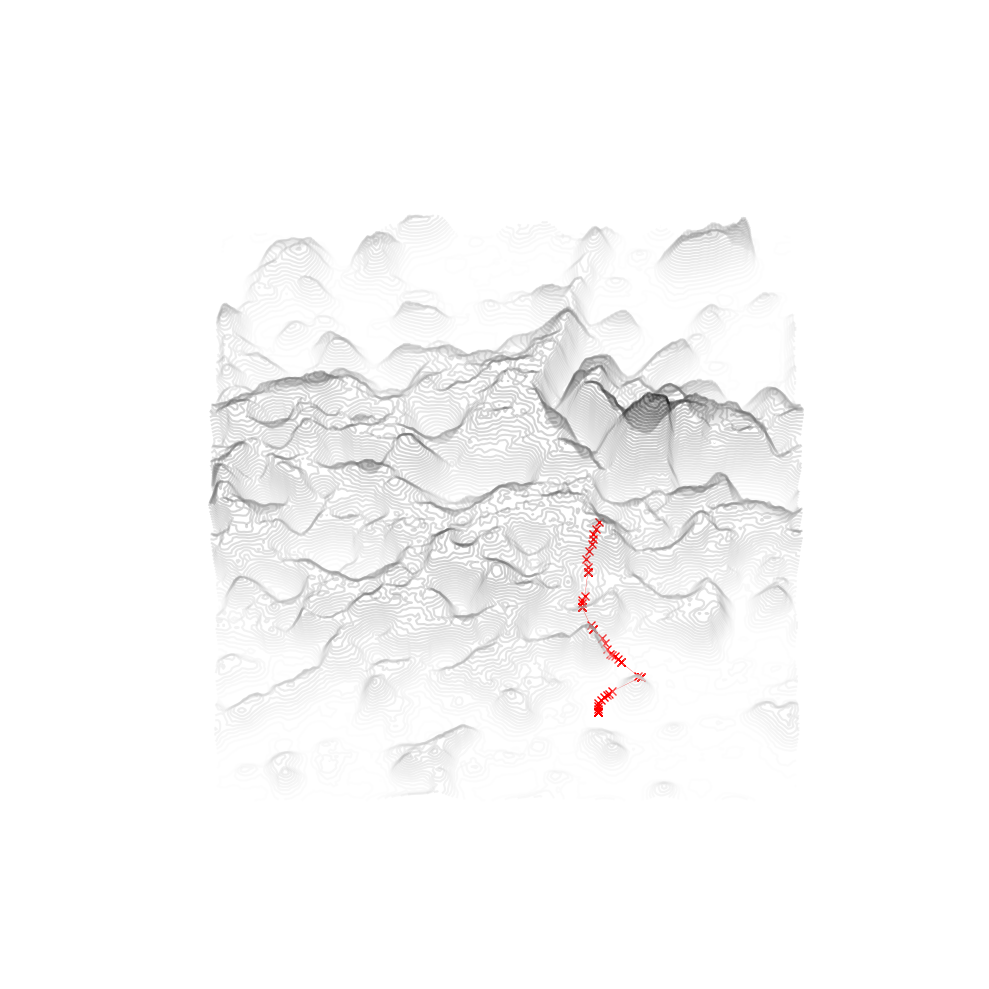

In [281]:
def plot_3d_descent(smx, start_idx):
    mat = buffer(smx)

    size = mat.shape[0]
    xs = ys = np.arange(size)
    X, Y = np.meshgrid(xs, ys)
    ids_list = descent(mat, start_idx)
    zt = [mat[xi, yi] for xi, yi in ids_list]
    xt, yt = zip(*ids_list)
    x, y, z = np.asarray(xt), np.asarray(yt), np.asarray(zt)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    # ax[i].plot_surface(-X, Y, mat, rstride=1, cstride=1, cmap='Greys', linewidth=0, antialiased=False)
    ax.contour3D(-X, Y, mat, 50, cmap='binary', alpha=0.3)
    # print(x)
    # print(len(ids_list))
    # print([len(i) for i in [x, y, z]])
    ax.plot3D(-y, x, z, '-x', markersize=6, linewidth=0.2, c='r')
    ax.view_init(80, 90)
    plt.xlabel('x')
    plt.xlim(-300, -100)
    plt.ylim(100, 300)
    plt.axis('off')
    fig.tight_layout()
    plt.show

plot_3d_descent(sm200, start_idx)

In [85]:
np.random.seed(102)
rar = np.random.randint(0, 100, 100)
rar = rar.reshape((10, 10))
print(rar, rar[3, 5])
next(rar, (4, 4), step=3)

[[ 0 78 66 73 72 45 72 73 79  7]
 [ 4 38 82 55  3 96  0 80 71 25]
 [28 27 71 30  4 47 89 99  2 43]
 [38 75 69 39  7 12 42 53 39 69]
 [89 96 43 14 81 25 95 13 22 96]
 [27 94 31 18 78 76 88  6 67 91]
 [42 66 51 54 64 13 77 20 35 68]
 [80 74 51 68 94 84 66 23 74 72]
 [94 64 37 56 49  1 66 23 76 80]
 [ 3 12 41 60 89 69 27 58  0 24]] 12
[[38 82 55  3 96  0 80]
 [27 71 30  4 47 89 99]
 [75 69 39  7 12 42 53]
 [96 43 14 81 25 95 13]
 [94 31 18 78 76 88  6]
 [66 51 54 64 13 77 20]
 [74 51 68 94 84 66 23]]
0 5


(1, 6)